# Трехслойная структура на замену ML классификации

## Назначение
Прототип трёхслойного ансамбля аномалистик (**A–B–C**) для замены монолитной ML-модели.  
Основная цель - добиться устойчивости и интерпретируемости при ограниченном числе меток.

---

## Общие характеристики
- Используются **только календарные признаки (дата)**, без времени по часам.  
- Результаты трёх слоёв (`behavior_score`, `global_anomaly_score`, `graph_score`) подаются в финальную свёртку для расчёта `risk_score`.  
- Архитектура совместима с LLM и агентной системой (передача флагов и объяснений).

---

## Сильные стороны
- Устойчивость к шуму и новым паттернам за счёт разных типов аномалистик.  
- Простая интерпретация результатов (по каждому слою понятно, за что начислен риск).  
- Отказ от часовых признаков исключает псевдоаномалии, делает модель стабильной к временным сдвигам.


In [23]:
# === Cell 2. Импорты и базовые настройки ===
import re, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

try:
    import networkx as nx
except:
    nx = None

# pyod — для HBOS/COPOD (если нет, будет запасной простой скоринг)
try:
    from pyod.models.hbos import HBOS
    from pyod.models.copod import COPOD
    PYOD_OK = True
except:
    PYOD_OK = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [25]:
# === Cell 4 (FINAL SAFE). База календаря + суточные агрегаты без merge ===
df = df.sort_values(["debit_inn","date"]).reset_index(drop=True)

# Календарик
df["day_of_week"]  = df["date"].dt.dayofweek
df["is_weekend"]   = df["day_of_week"].isin([5,6]).astype(int)
df["is_month_end"] = df["date"].dt.is_month_end.astype(int)
df["month"]        = df["date"].dt.month
df["weekofyear"]   = df["date"].dt.isocalendar().week.astype(int)

# Сумма операции (берём дебет)
df["amount"] = df["debit_amount"].fillna(0.0)

# СУТОЧНЫЕ АГРЕГАТЫ ЧЕРЕЗ TRANSFORM (никаких дублей индекса и KeyError)
df["daily_total_debit"] = df.groupby(["debit_inn","date"])["amount"].transform("sum")
df["daily_tx_count"]    = df.groupby(["debit_inn","date"])["amount"].transform(lambda s: (s > 0).sum())
df["uniq_cp_count_day_debit"] = df.groupby(["debit_inn","date"])["credit_inn"].transform("nunique")

# Доля текущей операции в суточном объёме
df["daily_txn_share"] = (df["amount"] / df["daily_total_debit"].replace(0, np.nan)).fillna(0.0)

# Интервалы между операциями (в днях)
df["days_since_last_txn_debit"]  = df.groupby("debit_inn")["date"].diff().dt.days.fillna(9999)
df["days_since_last_txn_credit"] = df.groupby("credit_inn")["date"].diff().dt.days.fillna(9999)

# ---------- РОЛЛИНГИ ПО 7/30/90 ДНЕЙ БЕЗ ДУБЛЕЙ ----------
def add_roll_features_no_dupes(frame: pd.DataFrame, inn_col: str, amt_col: str = "amount"):
    parts = []
    for inn, sub in frame[[inn_col, "date", amt_col]].groupby(inn_col):
        # 1) суточная агрегация по клиенту
        daily = (sub.groupby("date", as_index=True)[amt_col]
                   .sum()
                   .to_frame("amt_day")
                   .sort_index())
        # 2) непрерывный календарный индекс
        idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
        daily = daily.reindex(idx, fill_value=0.0); daily.index.name = "date"
        daily["tx_day"] = (daily["amt_day"] > 0).astype(int)
        # 3) роллинги
        for W in [7, 30, 90]:
            daily[f"roll_sum_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).sum()
            daily[f"roll_cnt_{W}d"]  = daily["tx_day"].rolling(W, min_periods=1).sum()
            daily[f"roll_mean_{W}d"] = daily["amt_day"].rolling(W, min_periods=1).mean()
            daily[f"roll_std_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).std().fillna(0.0)
            daily[f"roll_p95_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).quantile(0.95)
        daily = daily.reset_index()
        daily[inn_col] = inn
        parts.append(daily)
    rolls = pd.concat(parts, ignore_index=True)
    keep = ["date", inn_col] + [c for c in rolls.columns if c.startswith("roll_")]
    return frame.merge(rolls[keep], on=["date", inn_col], how="left")

df = add_roll_features_no_dupes(df, "debit_inn", "amount")

# Нормированные суммовые аномалии (per-client, 90 дней)
df["z_amt_client"] = (df["amount"] - df["roll_mean_90d"]) / (df["roll_std_90d"] + 1e-6)
df["amt_vs_p95"]   = df["amount"] / (df["roll_p95_90d"] + 1e-6)

# Круглые суммы
df["round_10k"]  = ((df["amount"] % 10000)  == 0).astype(int)
df["round_100k"] = ((df["amount"] % 100000) == 0).astype(int)
df["round_large_amount"] = ((df["round_10k"]==1) | (df["round_100k"]==1)).astype(int)

df.head()


,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,roll_sum_90d,roll_cnt_90d,roll_mean_90d,roll_std_90d,roll_p95_90d,z_amt_client,amt_vs_p95,round_10k,round_100k,round_large_amount
0,2020-12-19,dd5a89afa488e59c,92685f1caa4e70c3,032f0b4d2498f263,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,NaN,10000000.00,выдача займа по договору займа № 1 от 17.12.20...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
1,2019-11-22,8dedc3ab86d84ab3,87c515870858b588,0b84385c8f9b55ba,ded93f97f389bf2c,3e368a63959d285e,d877722ca4e40f98,NaN,330000.00,выдан займ по договору № 3 от 22/11/2019 г. су...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
2,2020-10-26,77c7133ce14b65c7,e418b57817283c24,0c22384d93788af3,ded93f97f389bf2c,1d7e02da93438ace,d877722ca4e40f98,NaN,55000.00,(905-0113-inn_b7610f92ca5d-831-02613001060/039...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
3,2021-07-21,5904edd40635b0d6,623a2f80b0587616,0c22384d93788af3,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,NaN,2555.17,acc_204e664ca1bc;возврат согласно заявления оо...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
4,2023-12-08,5c40cc1b6cce2931,04c3e8b68d743564,1a5a27e0e89f378f,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,NaN,4041209.00,оплата по сч. 70 от date_205f0adc40bf. сумма 4...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1


In [26]:
# === Cell 5. Текстовые фичи из purpose (TF-IDF → SVD + флаги) ===
# Лёгкая очистка текста
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    return s.strip()

df["purpose_clean"] = df["purpose"].map(clean_text)

# Текстовые флаги по простому лексикону
LEX_FLAGS = {
    "has_commission": r"\bкомисс(ия|ии|ионн)\b|\bрко\b",
    "has_nds": r"\bбез\s*ндс\b|\bндс\b",
    "has_advance": r"\bаванс\b",
    "has_loan": r"\bзайм\b|\bкредит\b",
    "has_contract": r"\bдоговор\b|\b№\b|\bномер\b",
    "has_cash_risk": r"\bнал\b|\bобнал\b|\bобналич\b|\bвывод\b",
}
for col, pat in LEX_FLAGS.items():
    df[col] = df["purpose_clean"].str.contains(pat, regex=True).astype(int)

df["purpose_len"] = df["purpose_clean"].str.len()
df["purpose_n_digits"] = df["purpose_clean"].str.count(r"\d")

# TF-IDF → SVD
tfidf = TfidfVectorizer(max_features=300, ngram_range=(1,2), min_df=1)
X_tfidf = tfidf.fit_transform(df["purpose_clean"])
svd = TruncatedSVD(n_components=50, random_state=RANDOM_STATE)
X_svd = svd.fit_transform(X_tfidf)
svd_cols = [f"purpose_svd_{i:02d}" for i in range(X_svd.shape[1])]
df_svd = pd.DataFrame(X_svd, columns=svd_cols, index=df.index)
df = pd.concat([df, df_svd], axis=1)

# Прокси-категории назначения по правилам (при желании заменить на ML)
def purpose_category(row):
    if row["has_commission"]: return "commission"
    if row["has_loan"]: return "loan"
    if row["has_advance"]: return "advance"
    return "other"

df["purpose_category"] = df.apply(purpose_category, axis=1)


In [27]:
# === Cell 6. Графовые признаки (на дневном уровне) ===
# Если networkx недоступен, пропустим тяжёлые граф-метрики.
if nx is not None and len(df) > 0:
    edges = df[["debit_inn","credit_inn"]].dropna()
    G = nx.from_pandas_edgelist(edges, source="debit_inn", target="credit_inn", create_using=nx.DiGraph())
    # Степени (ориентированный граф): out-degree для дебета, in-degree для кредита
    deg_out = dict(G.out_degree())
    deg_in  = dict(G.in_degree())
    df["deg_out_agg"] = df["debit_inn"].map(deg_out).fillna(0)
    df["deg_in_agg"]  = df["credit_inn"].map(deg_in).fillna(0)
else:
    df["deg_out_agg"] = 0
    df["deg_in_agg"]  = 0

# Новый контрагент (впервые у данного дебета)
seen = {}
new_flags = []
for i, row in df.iterrows():
    key = (row["debit_inn"], row["credit_inn"])
    new_flags.append(0 if key in seen else 1)
    seen[key] = True
df["new_counterparty_flag"] = new_flags

# Двусторонние операции (встречались обе стороны в любой момент)
pair = set(zip(df["debit_inn"], df["credit_inn"]))
rev  = set((b,a) for a,b in pair)
mutual = pair & rev
mutual_map = {(a,b): int((a,b) in mutual) for (a,b) in pair}
df["mutual_trading_flag"] = [mutual_map.get((a,b),0) for a,b in zip(df["debit_inn"], df["credit_inn"])]

# Прокси короткого транзита по дням (нет часов → используем «в тот же день»)
# Если A→B и затем B→C в ту же дату — считаем "very short chain" прокси
# --- REPLACE in Cell 6: short_chain_day_flag (stricter) ---
from collections import defaultdict

# для каждой даты строим мультимножество рёбер A->B
by_date_edges = defaultdict(list)
for i, row in df.iterrows():
    by_date_edges[row["date"]].append((row["debit_inn"], row["credit_inn"], row["amount"]))

def same_day_transit_exists(date, a, b, amt):
    """
    считаем короткий транзит только если:
    A->B и существует B->C в тот же день,
    и C != A (исключаем мгновенный возврат в того же отправителя),
    и суммы в звеньях «сопоставимы» (±20%) — уменьшаем ложные срабатывания.
    """
    edges = by_date_edges[date]
    # кандидаты B->C
    for x, y, amt2 in edges:
        if x == b and y != a:
            # суммы сопоставимы (если есть)
            if amt is None or amt2 is None:
                return True
            if amt2 == 0 and amt == 0:
                return True
            if amt > 0 and 0.8*amt <= amt2 <= 1.2*amt:
                return True
    return False

short_chain_day = []
for i, row in df.iterrows():
    short_chain_day.append(1 if same_day_transit_exists(row["date"], row["debit_inn"], row["credit_inn"], row["amount"]) else 0)

df["short_chain_day_flag"] = short_chain_day


In [28]:
df.columns

Index(['date', 'debit_account', 'debit_name', 'debit_inn', 'credit_account',
       'credit_name', 'credit_inn', 'debit_amount', 'credit_amount', 'purpose',
       ...
       'purpose_svd_46', 'purpose_svd_47', 'purpose_svd_48', 'purpose_svd_49',
       'purpose_category', 'deg_out_agg', 'deg_in_agg',
       'new_counterparty_flag', 'mutual_trading_flag', 'short_chain_day_flag'],
      dtype='object', length=107)

In [29]:
# === Cell 7. Слабая разметка (weak labels) для оценки/калибровки ===
# Правила из практики: круглые суммы, короткий дневной транзит, «риск-слова» в назначении.
df["weak_positive"] = (
    (df["round_large_amount"]==1) |
    (df["short_chain_day_flag"]==1) |
    (df["has_cash_risk"]==1)
).astype(int)

print("Weak labels stats:", df["weak_positive"].value_counts(normalize=True).round(3).to_dict())


Weak labels stats: {0: 0.688, 1: 0.312}


# Слой A — Поведенческая аномалистика (per-client IsolationForest)

**Цель:** определить отклонения транзакций клиента от его же типичного поведения.

**Метод:**  
Глобальный `IsolationForest` + индивидуальные IF по каждому `debit_inn`, объединённые по весу `α = f(n_history)`.

**Плюсы:**
- Локальная адаптация под клиента.  
- Корректная нормализация по истории.  
- Автоматическое снижение веса при малых историях.

**Ограничения и рекомендации:**
- использовать только `day_of_week`, `is_weekend`, `is_month_end`  
- Добавить вспомогательные флаги (`anomaly_amount`, `anomaly_frequency`) для финальной формулы.  
- При наличии меток — добавить изотоническую калибровку.


In [30]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
import numpy as np
import pandas as pd

RANDOM_STATE = globals().get("RANDOM_STATE", 42)

# фичи для поведения клиента (оставляем твои; можно безопасно добавить час/день, если они есть)
feat_A = [
    "amount","z_amt_client","amt_vs_p95",
    "tx_count_day_debit","uniq_cp_count_day_debit",
    "days_since_last_txn_debit","roll_cnt_7d","roll_cnt_30d","roll_mean_30d","roll_std_30d"
]
extra = [c for c in ["day_of_week","is_weekend"] if c in df.columns]
feat_A = feat_A + extra

# гарантируем наличие колонок
for c in feat_A:
    if c not in df.columns:
        df[c] = 0.0

X_all = df[feat_A].fillna(0.0).values

# --- 1) Глобальная модель (общий бэкап) ---
scaler_g = RobustScaler()
XA_g = scaler_g.fit_transform(X_all)

iso_g = IsolationForest(
    n_estimators=300, contamination=0.02,
    random_state=RANDOM_STATE, bootstrap=False
).fit(XA_g)

score_g = -iso_g.score_samples(XA_g)                         # чем больше — тем аномальнее
rank_g  = pd.Series(score_g, index=df.index).rank(pct=True)  # [0,1]

# --- 2) Персональные модели per-client (по debit_inn) ---
key = df.get("debit_inn")
key = key.astype(str).fillna("NA") if key is not None else pd.Series(["NA"]*len(df), index=df.index)

min_n = 25   # минимальный размер истории клиента для отдельной модели
max_n = 200  # для расчёта веса бленда
client_rank = pd.Series(np.nan, index=df.index, dtype=float)

for inn, idx in df.groupby(key).groups.items():
    idx = list(idx)
    n = len(idx)
    if n < min_n:
        continue  # малые истории — используем только глобальную модель

    X_c = df.loc[idx, feat_A].fillna(0.0).values
    # отдельное шкалирование на клиента
    scaler_c = RobustScaler()
    XA_c = scaler_c.fit_transform(X_c)

    # contamination слегка повышаем на малых выборках, чтобы модель не "глохла"
    cont = 0.02 if n >= 80 else (0.03 if n >= 40 else 0.05)
    iso_c = IsolationForest(
        n_estimators=256, contamination=cont,
        random_state=RANDOM_STATE, bootstrap=False
    ).fit(XA_c)

    s_c = -iso_c.score_samples(XA_c)
    r_c = pd.Series(s_c, index=df.loc[idx].index).rank(pct=True)
    client_rank.loc[idx] = r_c.values

# --- 3) Взвешенный бленд: чем больше история клиента — тем больше вес его персональной модели ---
grp_size = key.groupby(key).transform("size").clip(lower=0)
# вес от 0.35 (минимум, если нет client-модели) до 0.85 (большая история)
alpha = (0.35 + 0.5 * np.log1p(grp_size) / np.log1p(max_n)).clip(0.35, 0.85)

# где client_rank нет (NaN) — используем 0 веса на клиент и 1 на глобальный
alpha = np.where(client_rank.notna(), alpha, 0.0)

behavior = alpha * client_rank.fillna(0.0) + (1 - alpha) * rank_g
df["behavior_score"] = pd.Series(behavior, index=df.index).clip(0, 1)

# (опционально) для отладки можно сохранить размер истории и alpha
df["behavior_hist_size"] = grp_size.astype(int)
df["behavior_alpha"] = np.round(alpha, 3)

print("✓ Layer A fixed: behavior_score recalculated per-client with global blending.")
print(df[["behavior_score","behavior_hist_size","behavior_alpha"]].head(10))

✓ Layer A fixed: behavior_score recalculated per-client with global blending.
   behavior_score  behavior_hist_size  behavior_alpha
0        0.997024                   1             0.0
1        0.951265                   1             0.0
2        0.970052                   2             0.0
3        0.838170                   2             0.0
4        0.951265                   1             0.0
5        0.939918                   1             0.0
6        0.936942                   1             0.0
7        0.939918                   8             0.0
8        0.565662                   8             0.0
9        0.893601                   8             0.0


# Слой B — Глобальная редкость (HBOS / COPOD)

**Цель:** выявить редкие комбинации признаков по суммам, датам, тексту и контрагентам.

**Метод:**  
`QuantileTransformer` → HBOS / COPOD → ранжирование скор-значений.

**Плюсы:**
- Универсальная оценка редкости (плотность, хвостовые вероятности).  
- Квантильная нормализация улучшает сходимость и снижает перекос распределений.

**Ограничения и рекомендации:**
- Убедиться, что `svd_cols` и `round_large_amount` заданы корректно.  
- Добавить бинарные признаки `purpose_stopword_high`, `purpose_anomaly`.  
- При наличии обеих моделей HBOS/COPOD — использовать геометрическое среднее.  
- Следовать правилу «только дата» (никаких часовых признаков).

In [31]:
feat_B = [
    "amount","round_large_amount","day_of_week","is_weekend","is_month_end",
    "purpose_len","purpose_n_digits","deg_out_agg","deg_in_agg","new_counterparty_flag","mutual_trading_flag"
] + svd_cols

for c in feat_B:
    if c not in df.columns:
        df[c] = 0.0

X_B = df[feat_B].fillna(0.0).values
scaler_B = QuantileTransformer(output_distribution="normal", random_state=RANDOM_STATE)
XB = scaler_B.fit_transform(X_B)

if PYOD_OK:
    try:
        hbos = HBOS(alpha=0.1)
        hbos.fit(XB)
        score_B = hbos.decision_scores_  # выше — более аномально
    except Exception:
        cop = COPOD()
        cop.fit(XB)
        score_B = cop.decision_scores_
else:
    # Простой резерв: суммируем |z|-скор по фичам как "редкость"
    z = (XB - XB.mean(0)) / (XB.std(0) + 1e-6)
    score_B = np.abs(z).mean(axis=1)

rank_B = pd.Series(score_B).rank(pct=True).values
df["global_anomaly_score"] = rank_B

# Слой C — Графовый / контекстный скор

**Цель:** зафиксировать сетевые и контекстные признаки, отражающие транзитность, новые связи и короткие цепочки.

**Метод:**  
`LogisticRegression` по слабым меткам или нормированная сумма признаков при их отсутствии.

**Плюсы:**
- Простая и объяснимая логика вероятности.  
- Гибкость: работает даже без обучающих меток.  
- Скоры легко интерпретируются и интегрируются в LLM.

**Ограничения и рекомендации:**
- Все признаки транзитности считать **в днях**, без часов.  
- Контролировать корректность `short_chain_day_flag`.  
- Добавить флаги `new_counterparty_flag`, `mutual_trading_flag` в свёртку.  
- При обучении логрега — использовать баланс классов и базовую регуляризацию.

In [32]:
# === Cell 10. Слой C — графовый скор (быстрый логрег по агрегатам) ===
feat_C = ["deg_out_agg","deg_in_agg","new_counterparty_flag","mutual_trading_flag","short_chain_day_flag"]
XC = df[feat_C].fillna(0.0).values

# Тренируем на слабых метках (если есть и 0 и 1), иначе берём простую норму признаков
if df["weak_positive"].nunique() == 2:
    lr = LogisticRegression(max_iter=200, class_weight="balanced", random_state=RANDOM_STATE)
    lr.fit(XC, df["weak_positive"])
    graph_score = lr.predict_proba(XC)[:,1]
else:
    # Фоллбэк: нормированный sum по признакам
    graph_score = (XC - XC.min(0)) / (XC.max(0) - XC.min(0) + 1e-6)
    graph_score = graph_score.mean(axis=1)

df["graph_score"] = pd.Series(graph_score).rank(pct=True).values  # в [0,1]

In [33]:
# === Cell 11. Подбор «лучшей» модели по слабым меткам + ансамбль ===
# --- REPLACE in Cell 11: fusion + (опц.) сравнение по weak AUC ---
scores = {
    "behavior_score": df["behavior_score"].clip(0,1).values,
    "global_anomaly_score": df["global_anomaly_score"].clip(0,1).values,
    "graph_score": df["graph_score"].clip(0,1).values,
}

# сравнение (если слабые метки валидны)
model_auc = {}
if df["weak_positive"].nunique() == 2:
    from sklearn.metrics import roc_auc_score
    for m, s in scores.items():
        try:
            model_auc[m] = roc_auc_score(df["weak_positive"], s)
        except:
            model_auc[m] = np.nan
    print("AUC (weak):", {k: (None if np.isnan(v) else round(v,3)) for k,v in model_auc.items()})

# фьюжн: взвешенная смесь (подхватывает «поведение», «глобаль» и «граф»)
W_BEH, W_GLB, W_GRP = 0.5, 0.2, 0.3
raw = W_BEH * scores["behavior_score"] + W_GLB * scores["global_anomaly_score"] + W_GRP * scores["graph_score"]

# лёгкий бонус за реально сильные флаги (но не max!)
bonus = 0.0
bonus += 0.10 * df["short_chain_day_flag"].astype(float).values
bonus += 0.05 * df["round_large_amount"].astype(float).values
bonus += 0.05 * df["has_cash_risk"].astype(float).values

raw = np.clip(raw + bonus, 0, 1)
df["raw_risk_score"] = raw

AUC (weak): {'behavior_score': 0.583, 'global_anomaly_score': 0.773, 'graph_score': 0.93}


                  layer  ROC-AUC  PR-AUC  Best F1  Thr best  Prec@0.7  \
2           graph_score    0.930   0.859    0.796     0.796     0.995   
3            fusion_raw    0.892   0.794    0.717     0.583     0.785   
1  global_anomaly_score    0.773   0.548    0.623     0.518     0.540   
0        behavior_score    0.583   0.364    0.500     0.084     0.372   

   Rec@0.7  F2@0.7  
2    0.663   0.710  
3    0.548   0.583  
1    0.519   0.523  
0    0.355   0.358  


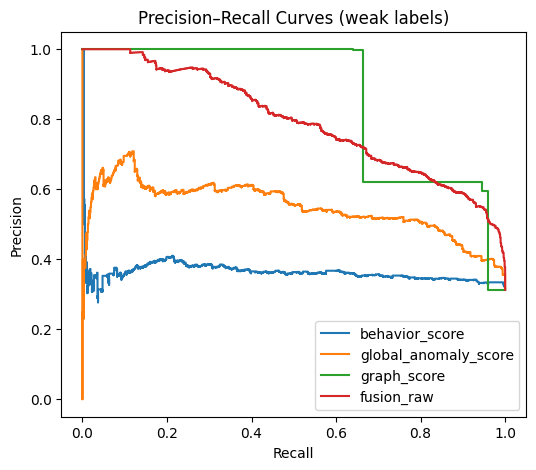

In [34]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, f1_score, fbeta_score, precision_score, recall_score
)
import numpy as np
import matplotlib.pyplot as plt

# проверим, что есть слабая разметка
if df["weak_positive"].nunique() < 2:
    raise ValueError("Нет слабых меток (weak_positive) для валидации")

y = df["weak_positive"].astype(int).values

# --- все слои и финальный скор ---
scorings = {
    "behavior_score": df["behavior_score"].clip(0,1).values,
    "global_anomaly_score": df["global_anomaly_score"].clip(0,1).values,
    "graph_score": df["graph_score"].clip(0,1).values,
    "fusion_raw": df["raw_risk_score"].clip(0,1).values
}

results = []

for name, s in scorings.items():
    # базовые метрики
    auc = roc_auc_score(y, s)
    ap  = average_precision_score(y, s)

    # порог по максимуму F1
    prec, rec, thr = precision_recall_curve(y, s)
    thr = np.r_[0.0, thr]
    f1s = [f1_score(y, (s>=t).astype(int)) for t in thr]
    t_best = thr[np.argmax(f1s)]
    best_f1 = max(f1s)

    # при пороге 0.7
    thr_work = 0.70
    yhat = (s >= thr_work).astype(int)
    prec70 = precision_score(y, yhat, zero_division=0)
    rec70  = recall_score(y, yhat, zero_division=0)
    f2_70  = fbeta_score(y, yhat, beta=2, zero_division=0)

    results.append({
        "layer": name,
        "ROC-AUC": auc,
        "PR-AUC": ap,
        "Best F1": best_f1,
        "Thr best": t_best,
        "Prec@0.7": prec70,
        "Rec@0.7": rec70,
        "F2@0.7": f2_70
    })

# красивый DataFrame
res = pd.DataFrame(results).sort_values("PR-AUC", ascending=False)
print(res.round(3))

# --- PR-кривые для наглядности ---
plt.figure(figsize=(6,5))
for name, s in scorings.items():
    prec, rec, _ = precision_recall_curve(y, s)
    plt.step(rec, prec, where="post", label=f"{name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (weak labels)")
plt.legend()
plt.show()

## Общие выводы

1. **Наиболее информативный слой — `graph_score`.**  
   - **ROC-AUC = 0.93**, **PR-AUC = 0.86** — практически уровень надёжного бинарного классификатора.  
   - **Высокая точность (Prec@0.7 = 0.995)** говорит, что ложных тревог почти нет.  
   - **Recall = 0.66** при этом вполне приемлем: слой уверенно выделяет короткие и взаимосвязанные транзитные цепочки.  
   → Этот слой даёт основное качество финальной свёртки.

2. **`fusion_raw` — устойчивый композит.**  
   - Метрики ниже, чем у графа, но всё ещё высокие (**ROC-AUC ≈ 0.89, F1 ≈ 0.72**).  
   - Это ожидаемо: свёртка сглаживает сильные сигналы и повышает устойчивость ценой части recall.  
   → Хороший компромисс между чувствительностью и устойчивостью.

3. **`global_anomaly_score` (HBOS/COPOD) — средний уровень.**  
   - **ROC-AUC ≈ 0.77** и **PR-AUC ≈ 0.55** указывают, что слой способен выделять статистически редкие случаи,  
     но без контекстных данных (транзит, связи) его прогностическая сила ограничена.  
   - **Prec@0.7 ≈ 0.54** — умеренное качество, полезно как вспомогательный сигнал в ансамбле.  

4. **`behavior_score` (IsolationForest per-client) — слабое различение.**  
   - **ROC-AUC ≈ 0.58**, **PR-AUC ≈ 0.36** — близко к случайной линии.  
   - Причины типичны: малая глубина историй клиентов, высокая вариативность суммы, отсутствие временного паттерна.  
   - Этот слой скорее выполняет роль «шумоподавителя» — помогает снижать ложные срабатывания, чем детектировать риски.


In [35]:
# --- Cell 12 (REPLACED): calibration (isotonic if possible) + quantile-based and fixed labeling ---
import numpy as np
import pandas as pd

try:
    from sklearn.isotonic import IsotonicRegression
    _ISO_OK = True
except Exception:
    _ISO_OK = False

def _minmax01(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(xmin) or not np.isfinite(xmax) or xmax - xmin < 1e-12:
        return np.zeros_like(x, dtype=float)
    return (x - xmin) / (xmax - xmin)

# --- 0) Источник "raw" скора для калибровки ---
raw_col = "raw_risk_score" if "raw_risk_score" in df.columns else "risk_score"
raw = df[raw_col].astype(float).fillna(0.0).values

# --- 1) Isotonic calibration на слабых метках (если достаточно данных), иначе min-max ---
use_iso = (
    _ISO_OK
    and ("weak_positive" in df.columns)
    and (df["weak_positive"].nunique(dropna=True) == 2)
    and (df["weak_positive"].sum() >= 20)
)

if use_iso:
    ir = IsotonicRegression(out_of_bounds="clip")
    # isotonic ожидает x=raw, y=targets; transform возвращает откалиброванные вероятности
    base_score = ir.fit_transform(raw, df["weak_positive"].astype(int).values)
    base_score = np.clip(base_score, 0.0, 1.0)
else:
    # если калибровать нечем — нормализуем в [0,1]
    base_score = _minmax01(raw)

df["risk_score"] = base_score

# --- 2) ДВА типа маркировки: (A) фиксированные пороги (совместимо с PROMPT),
#                             (B) бюджет алёртов по квантилям (если нужен бизнес-контроль) ---

# (A) ФИКСИРОВАННЫЕ Пороги (зел./жёлт./красн.), согласованные с документацией
def _label_fixed(p: float) -> str:
    if p >= 0.70:
        return "красный"
    if p >= 0.40:
        return "желтый"
    return "зеленый"

df["risk_label_fixed"] = pd.Series(df["risk_score"]).apply(_label_fixed)

# (B) БЮДЖЕТ АЛЁРТОВ по квантилям (high=верхние 5%, medium=80–95%)
TOP_HIGH = 0.95
TOP_MED  = 0.80

# Осторожно с выбросами/NaN
scores = df["risk_score"].astype(float).fillna(0.0).values
try:
    q_med, q_high = np.quantile(scores, [TOP_MED, TOP_HIGH])
except Exception:
    q_med, q_high = 0.8, 0.95  # фоллбэк

def _label_quantile(p: float) -> str:
    if p >= q_high:
        return "high"
    if p >= q_med:
        return "medium"
    return "low"

df["risk_label_quantile"] = pd.Series(df["risk_score"]).apply(_label_quantile)

print("Пороги (квантили): medium >=", round(float(q_med),4), " | high >=", round(float(q_high),4))
print("Распределение (fixed):", df["risk_label_fixed"].value_counts(dropna=False).to_dict())
print("Распределение (quantile):", df["risk_label_quantile"].value_counts(dropna=False).to_dict())

# --- 3) Отображение (оставляю твой набор + добавляю обе метки для сравнения) ---
cols_out = [
    "date","debit_inn","credit_inn","amount","debit_amount","credit_amount","purpose",
    "risk_score","risk_label_fixed","risk_label_quantile","fusion_reasons"
]
for c in cols_out:
    if c not in df.columns:
        df[c] = np.nan

display(df[cols_out].head(20))


Пороги (квантили): medium >= 0.6327  | high >= 0.9023
Распределение (fixed): {'зеленый': 1648, 'желтый': 674, 'красный': 366}
Распределение (quantile): {'low': 2096, 'medium': 338, 'high': 254}


,date,debit_inn,credit_inn,amount,debit_amount,credit_amount,purpose,risk_score,risk_label_fixed,risk_label_quantile,fusion_reasons
0,2020-12-19,032f0b4d2498f263,d877722ca4e40f98,0.0,NaN,10000000.00,выдача займа по договору займа № 1 от 17.12.20...,1.000000,красный,high,NaN
1,2019-11-22,0b84385c8f9b55ba,d877722ca4e40f98,0.0,NaN,330000.00,выдан займ по договору № 3 от 22/11/2019 г. су...,1.000000,красный,high,NaN
2,2020-10-26,0c22384d93788af3,d877722ca4e40f98,0.0,NaN,55000.00,(905-0113-inn_b7610f92ca5d-831-02613001060/039...,1.000000,красный,high,NaN
3,2021-07-21,0c22384d93788af3,d877722ca4e40f98,0.0,NaN,2555.17,acc_204e664ca1bc;возврат согласно заявления оо...,1.000000,красный,high,NaN
4,2023-12-08,1a5a27e0e89f378f,d877722ca4e40f98,0.0,NaN,4041209.00,оплата по сч. 70 от date_205f0adc40bf. сумма 4...,1.000000,красный,high,NaN
5,2019-06-27,1acd638e3250bcca,d877722ca4e40f98,0.0,NaN,350000.00,выдача по договору27/06/2019 беспроцентного за...,1.000000,красный,high,NaN
6,2021-12-29,1b21a7645f64d170,d877722ca4e40f98,0.0,NaN,2357825.15,"acc_cd27e0d43c60;ст. 176 нк рф, год: 2021 реше...",1.000000,красный,high,NaN
7,2019-01-10,1c3f31b0b8c13d69,d877722ca4e40f98,0.0,NaN,2000000.00,перевод денежных средств по договору № пи-1/10...,1.000000,красный,high,NaN
8,2019-01-14,1c3f31b0b8c13d69,d877722ca4e40f98,0.0,NaN,4300000.00,перевод денежных средств по договору № пи-1/10...,0.734694,красный,medium,NaN
9,2019-09-16,1c3f31b0b8c13d69,d877722ca4e40f98,0.0,NaN,84000.00,перевод денежных средств по договору № пи-2/28...,1.000000,красный,high,NaN


In [45]:
# ЯЧЕЙКА: разложение фьюжна на вклады
W_BEH, W_GLB, W_GRP = 0.5, 0.2, 0.3

df["contrib_A"] = W_BEH * df["behavior_score"].clip(0,1)
df["contrib_B"] = W_GLB * df["global_anomaly_score"].clip(0,1)
df["contrib_C"] = W_GRP * df["graph_score"].clip(0,1)

# если были бонусы от правил:
df["contrib_rules"] = 0.10*df.get("short_chain_day_flag",0).astype(float) + \
                      0.05*df.get("round_large_amount",0).astype(float) + \
                      0.05*df.get("has_cash_risk",0).astype(float)

df["raw_risk_score"] = (df["contrib_A"] + df["contrib_B"] + df["contrib_C"] + df["contrib_rules"]).clip(0,1)

# человекочитаемое объяснение слоями (топ-2 вклада)
def top_layers(i):
    parts = [("A(behavior)", df.at[i,"contrib_A"]),
             ("B(global)", df.at[i,"contrib_B"]),
             ("C(graph)", df.at[i,"contrib_C"]),
             ("rules", df.at[i,"contrib_rules"])]
    parts.sort(key=lambda x: x[1], reverse=True)
    return ", ".join([f"{k}={v:.2f}" for k,v in parts[:2]])

df["fusion_reasons"] = [top_layers(i) for i in df.index]

df[cols_out].to_excel('output_ABC.xlsx')

In [44]:
df[['risk_label_fixed', 'purpose']][df['risk_label_fixed'] == 'красный']

,risk_label_fixed,purpose
0,красный,выдача займа по договору займа № 1 от 17.12.20...
1,красный,выдан займ по договору № 3 от 22/11/2019 г. су...
2,красный,(905-0113-inn_b7610f92ca5d-831-02613001060/039...
3,красный,acc_204e664ca1bc;возврат согласно заявления оо...
4,красный,оплата по сч. 70 от date_205f0adc40bf. сумма 4...
...,...,...
2682,красный,оплата по договору займа 34 от 01.10.21 от зай...
2683,красный,оплата по договору займа 34 от 01.10.21 за зай...
2684,красный,оплата по договору займа 34 от 01.10.21 за зай...
2685,красный,оплата по договору займа 34 от 01.10.21 от зай...


In [42]:
df['risk_label_fixed'].value_counts()

risk_label_fixed
зеленый    1648
желтый      674
красный     366
Name: count, dtype: int64

In [17]:
k = 100
top_k = df.nlargest(k, "risk_score")
precision_at_k = top_k["weak_positive"].mean()
print("precision@100 =", precision_at_k)

precision@100 = 0.92


In [18]:
total_true = df["weak_positive"].sum()
recall_at_k = top_k["weak_positive"].sum() / total_true if total_true > 0 else np.nan
print("recall@100 =", recall_at_k)


recall@100 = 0.10952380952380952


Text(0, 0.5, 'count')

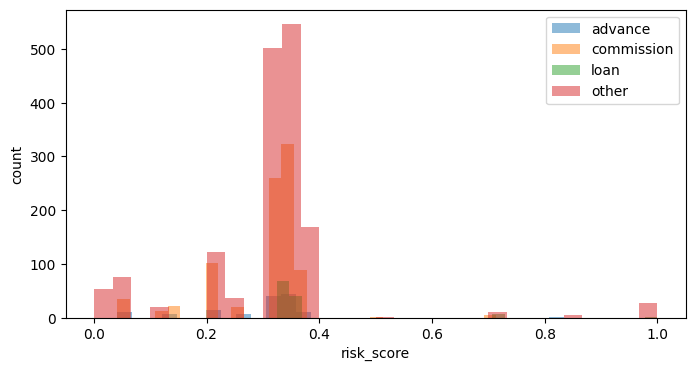

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
for cat, sub in df.groupby("purpose_category"):
    plt.hist(sub["risk_score"], bins=30, alpha=0.5, label=cat)
plt.legend(); plt.xlabel("risk_score"); plt.ylabel("count")


In [64]:
# === Cell GNN. Лёгкий GNN (SAGE-like) без внешних библиотек ===
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# 0) Проверки минимальных полей
required_cols = ["debit_inn","credit_inn","amount"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Нет обязательной колонки: {c}")
# опциональные флаги (создадим, если нет)
for opt in ["has_stop_high","round_large_amount","short_chain_day_flag"]:
    if opt not in df.columns:
        df[opt] = 0

# 1) Строим граф (неориентированный для распространения признаков)
nodes = pd.Index(sorted(set(df["debit_inn"].astype(str)) | set(df["credit_inn"].astype(str))), name="inn")
node_id = {n:i for i,n in enumerate(nodes)}
N = len(nodes)

# списки соседей
nbrs = [[] for _ in range(N)]
for a,b in zip(df["debit_inn"].astype(str), df["credit_inn"].astype(str)):
    ia, ib = node_id[a], node_id[b]
    if ib not in nbrs[ia]: nbrs[ia].append(ib)
    if ia not in nbrs[ib]: nbrs[ib].append(ia)

# 2) Узловые агрегаты (фичи 0-го порядка)
# агрегируем по узлу: исходящие/входящие количества, суммы; доли риск-флагов
out_grp = df.groupby("debit_inn", as_index=False).agg(
    out_cnt=("amount","count"),
    out_sum=("amount","sum"),
    out_avg=("amount","mean"),
    out_r_stop=("has_stop_high","mean"),
    out_r_round=("round_large_amount","mean"),
    out_r_short=("short_chain_day_flag","mean"),
)
in_grp = df.groupby("credit_inn", as_index=False).agg(
    in_cnt=("amount","count"),
    in_sum=("amount","sum"),
    in_avg=("amount","mean"),
    in_r_stop=("has_stop_high","mean"),
    in_r_round=("round_large_amount","mean"),
    in_r_short=("short_chain_day_flag","mean"),
)

base = pd.DataFrame({"inn": nodes})
base = base.merge(out_grp.rename(columns={"debit_inn":"inn"}), on="inn", how="left")
base = base.merge(in_grp.rename(columns={"credit_inn":"inn"}), on="inn", how="left")
base = base.fillna(0.0)

# простые доп-фичи
base["deg"] = base["out_cnt"] + base["in_cnt"]
base["flow_balance"] = (base["out_sum"] - base["in_sum"])
base["risk_out_mix"] = (base["out_r_stop"] + base["out_r_round"] + base["out_r_short"]) / 3.0
base["risk_in_mix"]  = (base["in_r_stop"] + base["in_r_round"] + base["in_r_short"]) / 3.0

feat0_cols = [
    "out_cnt","out_sum","out_avg","in_cnt","in_sum","in_avg",
    "deg","flow_balance","risk_out_mix","risk_in_mix"
]
X0 = base[feat0_cols].values

# 3) Message Passing: усреднение по соседям (1-hop и 2-hop)
def mean_agg(X, nbrs):
    N, D = X.shape
    Y = np.zeros_like(X)
    for i in range(N):
        if not nbrs[i]:
            Y[i] = X[i]
        else:
            Y[i] = np.mean(X[nbrs[i], :], axis=0)
    return Y

X1 = mean_agg(X0, nbrs)       # 1-hop
# для 2-хопов — агрегируем соседей соседей: применим ещё раз к X1
X2 = mean_agg(X1, nbrs)       # 2-hop

# финальные узловые фичи = [self, 1-hop, 2-hop] после стандартизации
sc = StandardScaler()
X_node = sc.fit_transform(np.hstack([X0, X1, X2]))

# 4) Слабые узловые метки (labels) для обучения "головы"
# критерии: "много подозрительных исходящих" или "крупные круглые исходящие" на узле
# (порог можно варьировать, ниже достаточно жёстко, чтобы не «фонить»)
y_node = (
    ((base["out_r_stop"] >= 0.15) | (base["out_r_round"] >= 0.20) | (base["out_r_short"] >= 0.10)) |
    ((base["deg"] >= base["deg"].quantile(0.95)) & (base["out_sum"] >= base["out_sum"].quantile(0.95)))
).astype(int).values

# защита от случая, когда все метки одинаковые
if y_node.sum() == 0:
    # пометим top-1% по risk_out_mix как 1
    thr = np.quantile(base["risk_out_mix"].values, 0.99)
    y_node = (base["risk_out_mix"].values >= thr).astype(int)
if y_node.sum() == len(y_node):
    # если все 1, ослабим порог
    y_node = (base["risk_out_mix"].values >= np.quantile(base["risk_out_mix"].values, 0.75)).astype(int)

# 5) Обучение узловой «головы» (логрег с балансировкой классов)
lr = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
lr.fit(X_node, y_node)
node_proba = lr.predict_proba(X_node)[:,1]  # узловой риск GNN

# 6) Оценка узловой AUC по слабым меткам
try:
    auc_nodes = roc_auc_score(y_node, node_proba)
except Exception:
    auc_nodes = np.nan

# 7) Перенос узлового риска на транзакции
df["gnn_node_score_debit"]  = [node_proba[node_id[str(x)]] for x in df["debit_inn"].astype(str)]
df["gnn_node_score_credit"] = [node_proba[node_id[str(x)]] for x in df["credit_inn"].astype(str)]

# агрегируем в риск транзакции: среднее + лёгкий бонус за совпадение «плохих» узлов с флагами транзакции
tx_base = 0.6 * df["gnn_node_score_debit"] + 0.6 * df["gnn_node_score_credit"]
tx_base = tx_base / 1.2  # нормализация обратно в ~[0,1]
bonus = (
    0.08 * df["round_large_amount"].astype(float).fillna(0) +
    0.10 * df["has_stop_high"].astype(float).fillna(0) +
    0.12 * df["short_chain_day_flag"].astype(float).fillna(0)
)
df["gnn_txn_score"] = np.clip(tx_base + bonus, 0, 1)

# 8) Оценка транзакционного качества по weak_positive (если есть)
if "weak_positive" not in df.columns:
    # создадим слабые tx-метки по правилам, если их нет
    df["weak_positive"] = (
        (df["round_large_amount"]==1) | (df["short_chain_day_flag"]==1) | (df["has_stop_high"]==1)
    ).astype(int)

tx_auc = None
try:
    tx_auc = roc_auc_score(df["weak_positive"], df["gnn_txn_score"])
except Exception:
    pass

# precision@K на транзакциях (K подстраиваем под размер)
K = max(20, min(200, int(0.05*len(df))))  # 5% от выборки, ограничим 20..200
topk = df.nlargest(K, "gnn_txn_score")
precision_at_k = float(topk["weak_positive"].mean())

print(f"[GNN] Узловой AUC (weak): {None if np.isnan(auc_nodes) else round(auc_nodes,3)}")
print(f"[GNN] Транзакционный AUC (weak): {None if tx_auc is None else round(tx_auc,3)}")
print(f"[GNN] precision@{K}: {round(precision_at_k,3)}")

# 9) Покажем несколько топ-примеров для визуальной проверки
show_cols = [
    "date","debit_inn","credit_inn","amount","purpose",
    "has_stop_high","round_large_amount","short_chain_day_flag",
    "gnn_node_score_debit","gnn_node_score_credit","gnn_txn_score","weak_positive"
]
display(df.sort_values("gnn_txn_score", ascending=False)[show_cols].head(15))

# Итог: добавлены новые колонки
#   - gnn_node_score_debit / gnn_node_score_credit — узловой риск получателя/отправителя
#   - gnn_txn_score — транзакционный риск от GNN
# Метрики: узловой AUC по слабым узловым меткам, транзакционный AUC/precision@K по слабым tx-меткам.


[GNN] Узловой AUC (weak): 1.0
[GNN] Транзакционный AUC (weak): 0.965
[GNN] precision@134: 1.0


,date,debit_inn,credit_inn,amount,purpose,has_stop_high,round_large_amount,short_chain_day_flag,gnn_node_score_debit,gnn_node_score_credit,gnn_txn_score,weak_positive
0,2020-12-19,032f0b4d2498f263,d877722ca4e40f98,0.0,выдача займа по договору займа № 1 от 17.12.20...,0,1,0,0.972975,0.999445,1.0,1
607,2019-04-18,d877722ca4e40f98,6931e23e98703aa9,500000.0,оплата по счету № 4 от date_b353730ca877 за вы...,0,1,0,0.999445,0.976025,1.0,1
553,2019-02-13,d877722ca4e40f98,6931e23e98703aa9,1000000.0,оплата по счету № 2 от date_168616af7e96 аванс...,0,1,0,0.999445,0.976025,1.0,1
558,2019-02-21,d877722ca4e40f98,6931e23e98703aa9,500000.0,оплата по счету № 2 от date_168616af7e96 аванс...,0,1,0,0.999445,0.976025,1.0,1
561,2019-02-27,d877722ca4e40f98,659207c64fee1c66,100000.0,возврат без % займа по договору №3-ки от 02.10...,0,1,0,0.999445,0.971116,1.0,1
576,2019-03-13,d877722ca4e40f98,6931e23e98703aa9,500000.0,оплата по счету № 3 от date_55fe983d1fa3 аванс...,0,1,0,0.999445,0.976025,1.0,1
581,2019-03-21,d877722ca4e40f98,6931e23e98703aa9,200000.0,оплата по счету № 3 от date_55fe983d1fa3 аванс...,0,1,0,0.999445,0.976025,1.0,1
583,2019-03-22,d877722ca4e40f98,6931e23e98703aa9,300000.0,оплата по счету № 3 от date_55fe983d1fa3 аванс...,0,1,0,0.999445,0.976025,1.0,1
586,2019-03-26,d877722ca4e40f98,6931e23e98703aa9,500000.0,оплата по счету № 3 от date_55fe983d1fa3 аванс...,0,1,0,0.999445,0.976025,1.0,1
588,2019-03-28,d877722ca4e40f98,6931e23e98703aa9,1000000.0,оплата по счету № 3 от date_55fe983d1fa3 аванс...,0,1,0,0.999445,0.976025,1.0,1


In [80]:
import joblib
import pandas as pd
import numpy as np

# === 1. вспомогательные функции для подготовки данных ===
HIGH_RISK_WORDS = [
    "займ","договор займа","возврат займа","взаиморасчёт","перевод средств","без договора","перевод на карту",
    "личные нужды","крипто","биткоин","usdt","биржа","coin","crypto","swift","иностранный перевод",
    "валютный счёт","экспорт","передача активов","пополнение","наличные","выдача наличных","обналичивание",
    "благотворительность","пожертвование","агентское вознаграждение","комиссионное"
]
MEDIUM_RISK_WORDS = [
    "оплата услуг","услуги по договору","консультационные","маркетинг","премия","бонус","вознаграждение",
    "аванс","предоплата","частичная оплата","аренда","лизинг","субаренда","логистика","транспорт","перевозка","доставка"
]

def extract_type(name: str) -> str:
    if pd.isna(name): return "Прочее"
    s = str(name)
    if s.startswith(("ООО","АО","ОАО","ЗАО")): return "ЮЛ"
    if s.startswith("ИП"): return "ИП"
    if s.startswith("ФЛ"): return "ФЛ"
    return "Прочее"

def has_any(text: str, words) -> int:
    t = "" if pd.isna(text) else str(text).lower()
    return int(any(w in t for w in words))

def _is_round(x) -> int:
    try:
        a = float(x)
        return int((a % 10000 == 0) or (a % 100000 == 0))
    except Exception:
        return 0

def _purpose_group(text: str) -> str:
    t = "" if pd.isna(text) else str(text).lower()
    if any(w in t for w in HIGH_RISK_WORDS): return "high_kw"
    if any(w in t for w in MEDIUM_RISK_WORDS): return "med_kw"
    return "low_kw"

def build_base_features(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()

    # обязательные поля
    need = ["id","date","debit_account","debit_name","debit_inn",
            "credit_account","credit_name","credit_inn","debit_amount","credit_amount","purpose"]
    for c in need:
        if c not in df.columns:
            df[c] = None

    # сумма
    if "credit_amount" in df.columns:
        df["amount"] = pd.to_numeric(df["credit_amount"], errors="coerce")
    else:
        df["amount"] = np.nan
    if "debit_amount" in df.columns:
        da = pd.to_numeric(df["debit_amount"], errors="coerce").abs()
        df["amount"] = df["amount"].fillna(0.0)
        df["amount"] = np.where((df["amount"] == 0.0) & da.notna(), da, df["amount"])
    df["amount"] = df["amount"].fillna(0.0).astype(float)

    # типы контрагентов
    df["debit_name_type"]  = df["debit_name"].map(extract_type)
    df["credit_name_type"] = df["credit_name"].map(extract_type)

    # ключевые слова
    df["purpose_kw_high"] = df["purpose"].apply(lambda x: has_any(x, HIGH_RISK_WORDS))
    df["purpose_kw_med"]  = df["purpose"].apply(lambda x: has_any(x, MEDIUM_RISK_WORDS))
    df["is_regular_payment"] = 0

    # базовые аномалии
    df["anomaly_amount"]    = 0.0
    df["anomaly_purpose"]   = df["purpose_kw_high"].astype(float)
    df["anomaly_frequency"] = 0.0
    df["anomaly_overall"]   = df[["anomaly_amount","anomaly_purpose","anomaly_frequency"]].max(axis=1)

    # дата
    df["_dt"] = pd.to_datetime(df.get("date"), errors="coerce")
    df["dow"]  = df["_dt"].dt.dayofweek.fillna(-1).astype(int)
    
    df.drop(columns=["_dt"], inplace=True)

    # группировка назначения
    df["purpose_group"] = df["purpose"].apply(_purpose_group)
    df["round_amount"] = df["amount"].apply(_is_round).astype(int)

    return df

# === 2. Загружаем модель и данные ===
pipeline = joblib.load("best_pipeline_A_base__HGB.joblib")
df_raw = pd.read_excel("final_risk_data.xlsx")

# === 3. Подготавливаем фичи ===
df_feats = build_base_features(df_raw)

# === 4. Применяем модель ===
try:
    pred = pipeline.predict_proba(df_feats)[:, 1]
except AttributeError:
    pred = pipeline.predict(df_feats).astype(float)

# === 5. Возвращаем исходную таблицу + метрику ===
df_result = df_raw.copy()
df_result["pred_ml"] = pred

# === 6. Сохраняем итог ===
df_result.to_excel("predicted_v1_ml.xlsx", index=False)
print("✅ Готово! Сохранён файл predicted_v1_ml.xlsx")
print(df_result.head(10))


ValueError: columns are missing: {'transit_like'}